### Phase 1 - Problem Definition  
#### 1.1 Broad Goals  

The purpose of this study is to identify fraudulent transactions in an extremely unbalanced dataset.  

#### 1.2 Data Source

The data is courtesy of the PaySim synthetic dataset available on Kaggle.  
https://www.kaggle.com/ntnu-testimon/paysim1

"PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world."

The kaggle dataset is scaled back to 1/4 the size of the original and simulates 30 days of mobile money transactions.

### Phase 2 - Data Gathering  
#### 2.1 Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#### 2.2 Load Data

In [2]:
df = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
# to make all columns camel case and labeled the same way

### Phase 3 - Exploratory Data Analysis  


    3.1 Dataset Shape   


In [3]:
df.shape

(6362620, 11)

The overall scale of the dataset is 6,362,620 transactions organized by time step and with 11 inherent features.

The primary takeaways we have from our exploratory data analysis are that some of the included features have little to no bearing on whether a transaction is labeled as fraudulent or not.  Out of the transaction types of 'cash in,' 'cash out,' 'debit,' 'payment,' and 'transfer,' fraudulent transactions are only included in the cash outs and transfers.  

When we examine the accounts and account names, we find that the account types of 'merchant' and 'customer' have little connection to which transactions are fraudulent, and in fact are inconsistently applied.  Additionally, only a very few accounts have more than 1 fraudulent transaction either to or from.

When we narrow our focus to only the transaction types that contain fraud, a few factors emerge; 
- the overall number of fraudulent transactions per hour (time step) remain relatively constant despite the total number of all transactions per step being variable.  
- the strongest correlations fraudulent activity are in the balance columns of the source and target accounts of the transaction.

After exploring this connection further, we start finding that there are errors in both the source accounts and destination accounts.  There are examples where the actual balance of the account money is being transferred to doesn't match the amount transferred.  For example:
- The old balance is 0 
- The transferred amount is 23.00 
- The new balance is 0
In this case, we would expect the account balance to be 23.00, when it is instead 0, so our target account variance is  23.00, or $23 of unaccounted for money.

This is our best link yet. The variance in the transaction's target account show a clear difference between fraudulent and legitimate transactions. The target account's variance rarely if ever goes negative for fraudulent transactions. In a nutshell, the fraudulent accounts are more likely to have a positive amount of money that is unaccounted for by the recorded transactions.

    3.2 Fraud by Transaction Type   


In [4]:
df['isFlaggedFraud'].value_counts(normalize=True)

0    0.999997
1    0.000003
Name: isFlaggedFraud, dtype: float64

In [5]:
df['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [6]:
df.groupby(by = ['type'])['isFraud'].value_counts(normalize = True)

type      isFraud
CASH_IN   0          1.000000
CASH_OUT  0          0.998160
          1          0.001840
DEBIT     0          1.000000
PAYMENT   0          1.000000
TRANSFER  0          0.992312
          1          0.007688
Name: isFraud, dtype: float64

At the moment we're ONLY seeing fraud samples in the CASH_OUT and TRANSFER categories.  We might be able to narrow our field of vision to focus on only these two categories.

    3.3 Examining Confirmed Fraud Samples   
 

In [7]:
df = df[(df['type'] == 'CASH_OUT' ) | (df['type'] == 'TRANSFER')]

In [8]:
df['isFraud'].value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

In [9]:
df['isFraud'].value_counts(normalize = True)

0    0.997035
1    0.002965
Name: isFraud, dtype: float64

Even in the categories that have confirmed fraud, we're only seeing 8.2k samples of fraud out of 2.7m samples.  Still a highly unbalanced class, although we've improved the positively identified cases from 0.13 % to 0.3 %.  This means that our baseline for our target column will need to be better than 99.7% accurate.  Let's see if we can improve on that.

In [10]:
def cust_or_merch(cell):
    if "M" in str(cell):
        return "M"
    else:
        return "C"
    
df['origAccountType'] = df['nameOrig'].apply(cust_or_merch)
df['destAccountType'] = df['nameDest'].apply(cust_or_merch)

In [11]:
df['origAccountType'].value_counts()

C    2770409
Name: origAccountType, dtype: int64

In [12]:
df['destAccountType'].value_counts(normalize = True)

C    1.0
Name: destAccountType, dtype: float64

"M" type accounts are merchants accounts, originating no transactions and receiving 33.8% of transactions.

In [13]:
df.groupby('destAccountType')['isFraud'].value_counts()

destAccountType  isFraud
C                0          2762196
                 1             8213
Name: isFraud, dtype: int64

And I'm not showing any merchant accounts being confirmed as fraudulent. The merchant prefix of 'M' does not appear to include any examples.  We'll leave this in for now to see if we can spot a correlation once we bring it to the number line, but we might ultimately drop it from the model as so far it seems an irrelevant feature.

    3.4 Exploring Engineered Features   


Okay, the strongest correlation to fraud is in the oldBalanceOrig column,almost all of the other existing columns are showing very low correlation coefficients. I'll have to try and engineer some features that have stronger coefficients for the model to pick up on.

In [14]:
df[(df['oldBalanceDest']== 0) & (df['newBalanceDest']== 0) & (df['amount'] != 0)].shape[0]

5776

Inspired by observations that there are nearly 6k transactions where the total amount of the origin account is transferred to an empty new account, we tried engineering some features to examine that relationship.

In [15]:
df['expectedBalanceDest'] = df['oldBalanceDest'] + df['amount']
df[df['expectedBalanceDest'] != df['newBalanceDest']]['isFraud'].value_counts(normalize = True)

0    0.995435
1    0.004565
Name: isFraud, dtype: float64

In [16]:
df['isFraud'].value_counts(normalize = True)

0    0.997035
1    0.002965
Name: isFraud, dtype: float64

In [17]:
df['expectedBalanceOrig'] = df['oldBalanceOrig'] - df['amount']
df[df['expectedBalanceOrig'] != df['newBalanceOrig']]['isFraud'].value_counts(normalize = True)

0    0.999951
1    0.000049
Name: isFraud, dtype: float64

The pattern we start to see is in the accounts where the expected balance and the actual balance post transaction do not line up. For example:  
    - The old balance is 0
    - The transferred amount is 23.00
    - The new balance is 0

In this case, we would expect the account balance to be 23.00, when it is instead 0, so our target account variance is + 23.00, or $23 of unaccounted for money.

We'll also apply this test to the origin or source account.

In [18]:
# prior balance of target account + amount transferred - new balance of target account
df['tarDiff'] = df['oldBalanceDest'] + df['amount'] - df['newBalanceDest']
# and for good measure, let's apply the test to the source account as well
# prior balance of source account + amount transferred - new balance of source account
df['sourceDiff'] = df['newBalanceOrig'] + df['amount'] - df['oldBalanceOrig']

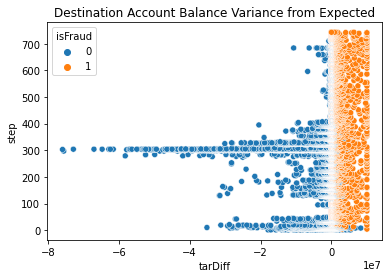

In [19]:
sns.scatterplot(x = 'tarDiff',y = 'step', hue = 'isFraud', data = df )
plt.title('Destination Account Balance Variance from Expected')
plt.savefig('./imgs/tarAccountVariance.jpg')

After trying several different visualizations, we get our clearest difference so far.  The errors in the transfer's target account show a clear difference between fraudulent and legitimate transactions.  The target account's variance rarely if ever goes negative for fraudulent transactions. In a nutshell, the fraudulent accounts are more likely to have a positive amount of money that is unaccounted for by the recorded transactions.

    3.5 Correllation to Fraud   

In [20]:
# EDA indicated 3 columns were irrelevant:

df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

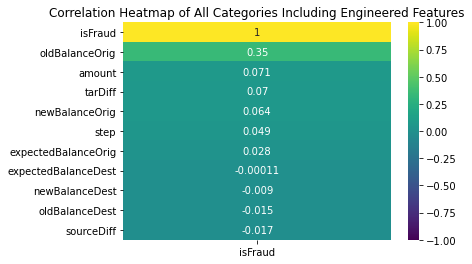

In [21]:
sns.heatmap(df.corr()[['isFraud']].sort_values(by = 'isFraud', ascending = False),
            vmin = -1,
            vmax = 1,
            cmap = 'viridis',
            annot = True)
plt.title('Correlation Heatmap of All Categories Including Engineered Features')
plt.savefig('./imgs/correlationHeatmap.jpg')

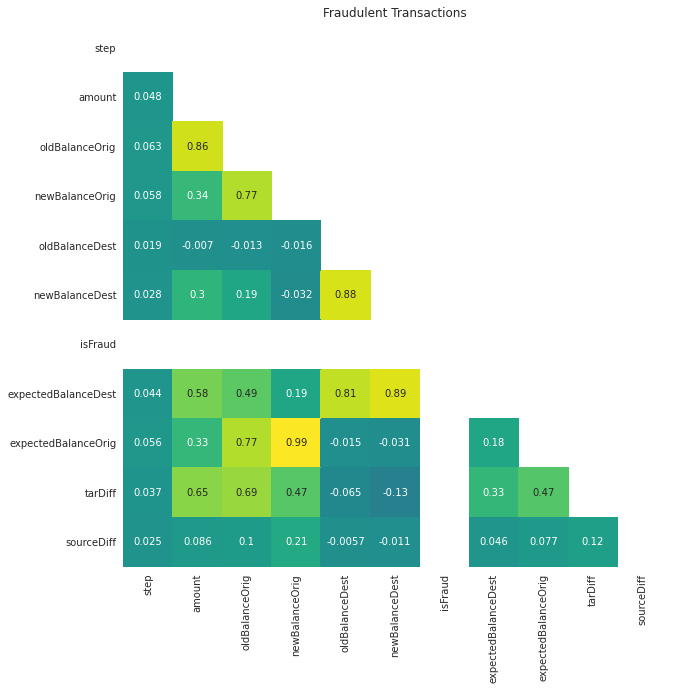

In [22]:
fraud = df[df['isFraud']== 1]
mask = np.zeros_like(fraud.corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    f, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(fraud.corr(), 
                     mask = mask, 
                     vmin = -1, 
                     vmax = 1, 
                     square = True, 
                     cmap = 'viridis', 
                     annot = True,
                     cbar = False)
    plt.title("Fraudulent Transactions")
    plt.savefig('./imgs/fraud_corr_heatmap.jpg')

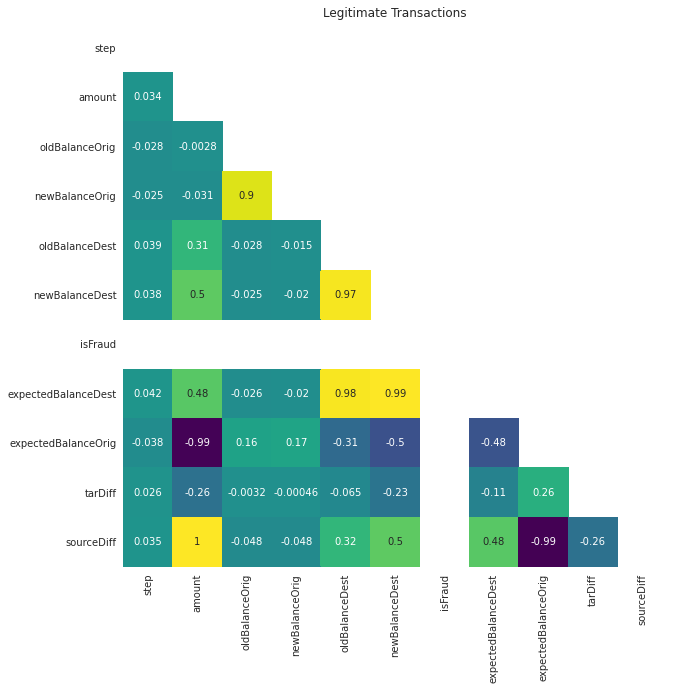

In [23]:
notFraud= df[df['isFraud']== 0]
mask = np.zeros_like(notFraud.corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    f, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(notFraud.corr(),
                     mask = mask, 
                     vmin = -1, 
                     vmax = 1, 
                     square = True, 
                     cmap = 'viridis', 
                     annot = True,
                     cbar = False)
    plt.title("Legitimate Transactions")
    plt.savefig('./imgs/not_fraud_corr_heatmap.jpg')

Comparing the correlation heatmaps of the two main categories of fraudulent and legitimate transactions, we can see a clear differences in the corrlations of the expected balances and balance variances between the two categories.  This confirms we're on the right path and that we'll have patterns our model will be able to pick up on.

### Phase 4 - Modeling  

    4.1 Load a fresh copy of the data.

In [24]:
df = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

    4.2 Clean, transform, and engineer features

In [25]:
# to make all columns camel case and labeled the same way
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

# EDA indicated 3 columns were irrelevant:

df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# EDA indicated fraudulent transactions only occur in CASH_OUT and TRANSFER types

df = df[(df['type'] == 'CASH_OUT' ) | (df['type'] == 'TRANSFER')]

# engineered columns 
df['sourceBalanceDiff'] = df['newBalanceOrig'] + df['amount'] - df['oldBalanceOrig']
df['tarBalanceDiff'] = df['oldBalanceDest'] + df['amount'] - df['newBalanceDest']

# bringing all categories to the number line
df = pd.get_dummies(columns = ['type'], drop_first = True, data = df)

    4.3 Train/Test/Split  

In [26]:
X = df.drop(columns = ['isFraud'])
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    stratify = y)
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

    4.4 Methods for Handling Imbalanced Classes   
        - oversampling   
        - undersampling  
        - SMOTE 

Because we're dealing with a highly skewed and imbalanced dataset, my different modeling notebooks explored different methods of handling imbalanced data, including oversampling, undersampling, and the SMOTE technique.  Interestingly, the best results were with the core unaltered dataset.  

### Phase 5 - Model Analysis  

    5.1 Baseline Score

In [27]:
df['isFraud'].value_counts(normalize = True)

0    0.997035
1    0.002965
Name: isFraud, dtype: float64

Our baseline for this model is 99.7 %:  meaning that this is such an imbalanced or skewed dataset where simply accepting 0.2% misclassifications and assuming all transactions are legitimate allows us to reach what would be an exceptional rate for other models.  Unfortunately this misses the point of detecting fraud, so we'll just have to beat this standard.

    5.2 Model Selection

After several trials, the model that performs the best is the Random Forest Classifier, a model type that excels with handling imbalanced datasets.  Interestingly enough, when using the oversampling the minority class, the misclassificaiton rate more than doubled to 20 samples, when undersampling the majority class it rose to 207 samples, and when using a combination of under and oversampling (SMOTE), the misclassification rate hit 40 samples. 

Refer to the comparative modeling, logreg and rfclassifier notebooks for more detailed analysis and examination of other model types.

    5.3 Random Forest Classifier - Best Parameters   
    
Gridsearching and tuning the random forest resulted in a model that is 99.9987% accurate, with a total of 7 misclassifications in the 692,603 reserved testing samples.  


In [28]:
rfc = RandomForestClassifier(n_estimators = 50, criterion = 'entropy')
rfc.fit(Z_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=50)

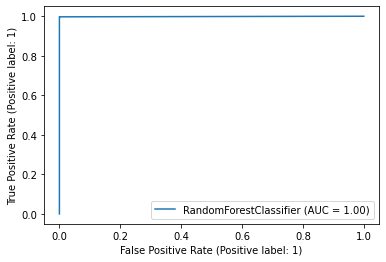

In [29]:
plot_roc_curve(rfc, Z_test, y_test)

Because we're dealing with such a large, and unbalanced dataset, the RFC classifier increases the area under the ROC curve to effectively perfect, so it's not going to be the best indicator in this case.  Let's take a look at the confusion matrix.

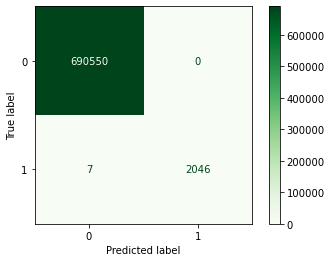

In [30]:
plot_confusion_matrix(rfc, Z_test, y_test, cmap = 'Greens')

Now we're talking!  This model gets a mere 7 samples incorrect out of a reserved testing set of 692,603.  Unfortunately it misses 7 cases of fraudulent activity, however this is a drastic improvement over missing 2053, which would have been lost in assuming all transactions were legit.

### Phase 6 - Conclusions  

    6.1 Revisit 1.3 Problem Statement  

The original purpose of this project is to develop a model that identifies fraudulent transactions in an extremely unbalanced dataset and serve as proof of concept for handling similar datasets in the future.  

    6.2 Conclusions  

This model succeds in the base concept.  It gets a mere 7 samples incorrect out of a reserved testing set of 692,603.  Unfortunately it misses 7 cases of fraudulent activity, however this is a drastic improvement over missing 2053, which would have been lost in assuming all transactions were legit.


    6.3 Recommendations for Further Research 

Attempts to tune the model to prefer false positives (labeling a legitimate transaction as fraudulent) rather than false negatives (missing a case of fraud) drastically decreased the overall accuracy as well as both the total number of false negatives and false positives.  I've been working with additional models that are reputed handle imbalanced classes well (XGboost, for example) and I'm excited to see what results I can get with another model in the mix.

###  Acknowledgements

PaySim first paper of the simulator:

E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016

Engineered error columns inspired by Arjun Joshua's award winning kaggle notebook:
https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services?rvi=1&scriptVersionId=2200418&cellId=1